In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# Plot N(R)

In [95]:
f = fits.open('output/BigMD_spherical_vsf.fits')
f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                   15 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'R       '           / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TTYPE2  = 'N       '           / label for field   2                            
TFORM2  = '1E      '           / data format of field: 4-byte REAL              
TTYPE3  = 'n       '        

In [285]:
def vsf(fn):
    f = fits.open(fn)
#     r = f[1].data['rmean']
#     dn = f[1].data['dn/dlnR']
    R = f[1].data['R']
    N = f[1].data['N']
    n = f[1].data['n']
    f.close()
    
    # determine survey volume
    vol = N[-1][0]/n[-1][0]
    print('Volume: %d [Mpc^3]' % vol)
    
    rmean = np.zeros(len(R)-1)
    dn = np.zeros_like(rmean)
    err = np.zeros_like(rmean)
    for i in range(0,len(R)-1):
        norm = vol * np.log(R[i]/R[i+1])
        rmean[i] = 0.5 * (R[i] + R[i+1])
        dn[i] = N[i+1]/norm  # dn/dlnR
        err[i] = np.sqrt(N[i+1])/norm  # Poisson uncertainty
    
    # remove bins with no voids
    mask = np.where(dn != 0)[0]

    return rmean[mask], dn[mask], err[mask]

def plot_vsf(fns, residual=False, **kwargs):
    
    # add a residual plot
    if residual==True:
        fig, (ax, ax1) = plt.subplots(2,1, sharex=True)
    else:
        fig, ax = plt.subplots(1)
    
    for (i,fn) in enumerate(fns):
        plot_kwargs = dict()
        for n in kwargs.keys():
            plot_kwargs[n] = kwargs[n][i]
        ax.errorbar(*vsf(fn), capsize=2, **plot_kwargs)
        
        if residual==True:
            if i==0: continue

            # cutsky
            R_cut, N_cut, err_cut = vsf(fns[i])

            # box
            R, N_box, err_box = vsf(fns[0])[-R_cut.size:]
            # cut to cutsky range
            R_box = R[-R_cut.size:]
            N_box = N_box[-R_cut.size:]
            err_box = err_box[-R_cut.size:]

            err_comb = np.sqrt((err_cut/N_cut)**2 
                             + (err_box/N_box)**2)

            ax1.errorbar(R_cut, N_cut/N_box - 1, err_comb, **plot_kwargs)
            ax1.hlines(0, R_cut[-1], R[0], kwargs['c'][0], '--')
            ax1.set_xlabel('r ($h^{-1}$ Mpc)', fontsize=14)
            ax1.set_ylabel('Residual', fontsize=14)
        else:
            ax.set_xlabel('r ($h^{-1}$ Mpc)', fontsize=14)
            
    ax.set_ylabel('dn/dlnR ($h^{-1}$ Mpc)$^{-3}$', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(which='major',axis='y')
    ax.grid(which='minor',axis='x')
    ax.legend()
    

## Effect of randoms

Volume: 15624985600 [Mpc^3]
Volume: 15737410560 [Mpc^3]


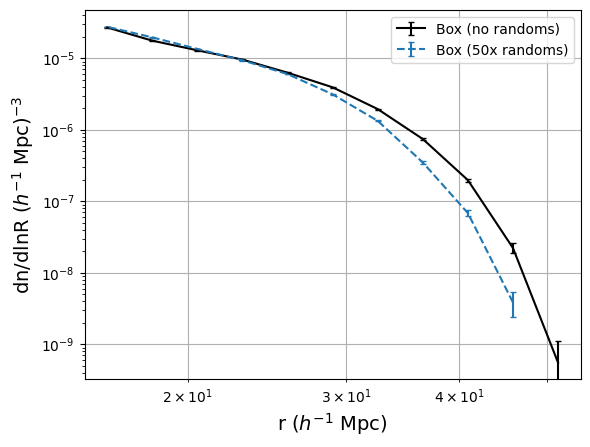

In [277]:
fns = ['output/BigMD_spherical_vsf.fits',
       'output/BigMDfullsky50_spherical_vsf.fits']
#        'output/BigMDfullsky20_spherical_vsf.fits',
#        'output/BigMDfullsky10_spherical_vsf.fits']
kwargs = dict(c=['k','C0','C1','C2'], 
              ls=['-','--','--','--'],
              label=['Box (no randoms)', 
                     'Box (50x randoms)', 
                     'Box (20x randoms)', 
                     'Box (10x randoms)'])
plot_vsf(fns, **kwargs)

## Effect of cutsky geometry

Volume: 15737410560 [Mpc^3]
Volume: 2016946304 [Mpc^3]
Volume: 2016946304 [Mpc^3]
Volume: 15737410560 [Mpc^3]


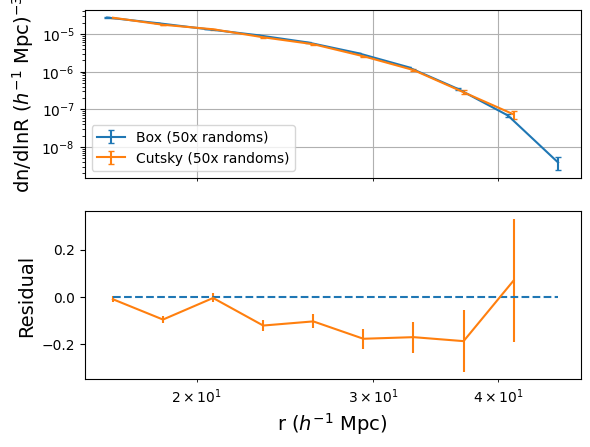

In [286]:
fns = ['output/BigMDfullsky50_spherical_vsf.fits',
       'output/BigMDcutsky50_spherical_vsf.fits']
#        'output/BigMDcutsky20_spherical_vsf.fits',
#        'output/BigMDcutsky10_spherical_vsf.fits']
kwargs = dict(c=['C0','C1'], 
              ls=['-','-'],
              label=['Box (50x randoms)', 'Cutsky (50x randoms)'])
plot_vsf(fns, residual=True, **kwargs)